In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from datetime import datetime
import time
import matplotlib.pyplot as plt

# Import raw data

In [2]:
def import_data(fileName):
    raw_data_df = pd.read_csv(fileName, header=0)
    return raw_data_df


In [3]:
raw_data_df = import_data('usage_train.csv')
raw_data_df.head()

,id,datetime,usage
0,MAC003828,2012-12-17 09:00:00,0.073
1,MAC003828,2012-12-17 09:30:00,0.054
2,MAC003828,2012-12-17 10:00:00,0.069
3,MAC003828,2012-12-17 10:30:00,0.070
4,MAC003828,2012-12-17 11:00:00,0.049


In [4]:
raw_test_data_df = import_data('usage_test.csv')
raw_test_data_df.head()

,id,datetime
0,MAC003828,2013-12-10 09:00:00
1,MAC003828,2013-12-10 09:30:00
2,MAC003828,2013-12-10 10:00:00
3,MAC003828,2013-12-10 10:30:00
4,MAC003828,2013-12-10 11:00:00


In [5]:
meter_id = 'MAC005415'
result=raw_data_df.loc[(raw_data_df.id == meter_id)]
result['date']=pd.to_datetime(result['datetime'])
data=result.loc[:, ['usage']]

data = data.set_index([result.date])

data['usage'] = pd.to_numeric(data['usage'],downcast='float',errors='coerce')

result_test=raw_test_data_df.loc[(raw_test_data_df.id == meter_id)]
result_test['date']=pd.to_datetime(result_test['datetime'])


/home/anil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/anil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [6]:
result_test.head()


,id,datetime,date
672,MAC005415,2013-12-10 09:00:00,2013-12-10 09:00:00
673,MAC005415,2013-12-10 09:30:00,2013-12-10 09:30:00
674,MAC005415,2013-12-10 10:00:00,2013-12-10 10:00:00
675,MAC005415,2013-12-10 10:30:00,2013-12-10 10:30:00
676,MAC005415,2013-12-10 11:00:00,2013-12-10 11:00:00


In [7]:
data.head()

,usage
date,
2012-12-17 09:00:00,0.018
2012-12-17 09:30:00,0.119
2012-12-17 10:00:00,0.110
2012-12-17 10:30:00,0.054
2012-12-17 11:00:00,0.079


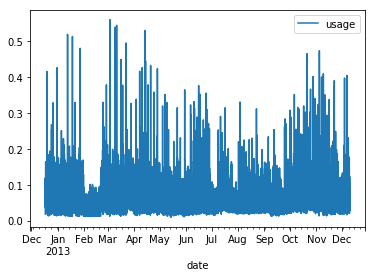

,usage
count,17184.000000
mean,0.070247
std,0.044182
min,0.009000
25%,0.041000
50%,0.061000
75%,0.090000
max,0.561000


In [8]:
data.plot()
plt.show()
data.dropna().describe()

In [9]:
weekly = data.resample('w').mean()

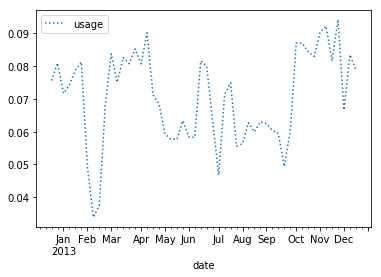

In [10]:
weekly.plot(style=[':', '--', '-'])

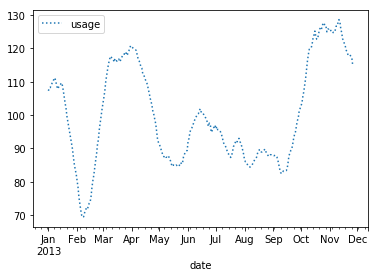

In [11]:
daily = data.resample('D').sum()
daily.rolling(30, center=True).sum().plot(style=[':', '--', '-'])

In [12]:
day= data.resample(rule='H').sum()
day.head()

,usage
date,
2012-12-17 09:00:00,0.137
2012-12-17 10:00:00,0.164
2012-12-17 11:00:00,0.104
2012-12-17 12:00:00,0.115
2012-12-17 13:00:00,0.143


In [13]:
half_hours= data.resample(rule=('T',30)).sum()
half_hours.head()

,usage
date,
2012-12-17 09:00:00,0.018
2012-12-17 09:30:00,0.119
2012-12-17 10:00:00,0.110
2012-12-17 10:30:00,0.054
2012-12-17 11:00:00,0.079


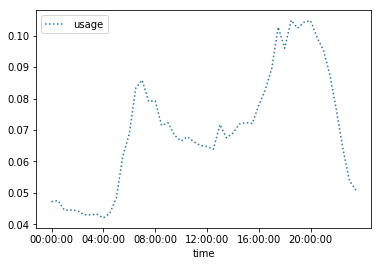

In [14]:
by_time = data.groupby(data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-']);

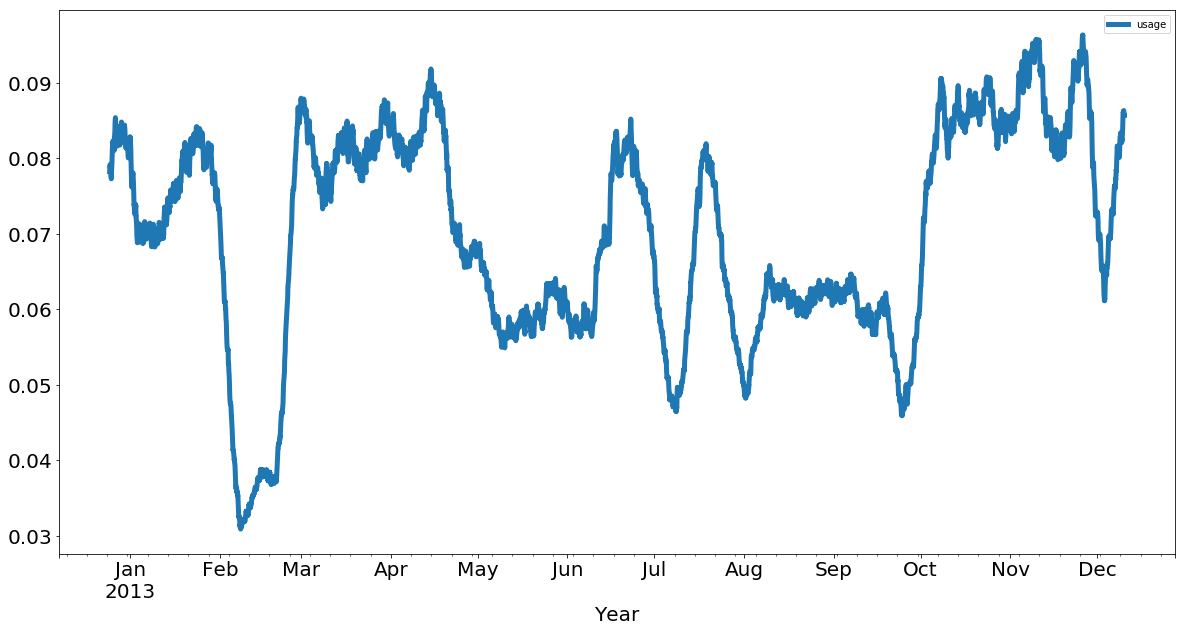

In [15]:
data.rolling(360).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

# LSTM prediction

In [16]:
mydata=daily.loc[:, ['usage']]
mydata = mydata.set_index(daily.index)
mydata.head()

,usage
date,
2012-12-17,2.616000
2012-12-18,3.600577
2012-12-19,4.041000
2012-12-20,3.246000
2012-12-21,3.333000


In [17]:
#Use MinMaxScaler to normalize 'KWH/hh (per half hour) ' to range from 0 to 1
from sklearn.preprocessing import MinMaxScaler
values = mydata['usage'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [18]:
train_size = int(len(scaled) * 0.8)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

287 72


In [19]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)


In [20]:
look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


283
68


In [21]:
train.shape

(287, 1)

In [22]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [23]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

Using TensorFlow backend.


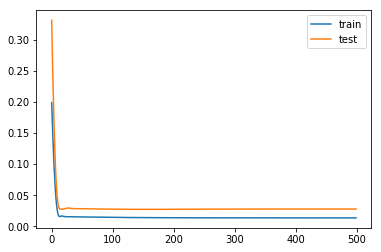

In [24]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [25]:
len(history.history['val_loss'])  

500

In [26]:
[l-v for l, v in zip(history.history['loss'], history.history['val_loss'])]

[-0.13251915289740682,
 -0.11268652843923535,
 -0.094707393261864,
 -0.07873365404117234,
 -0.0645356388769175,
 -0.05203039654573366,
 -0.04156694663918903,
 -0.03290082463606297,
 -0.026053815665440933,
 -0.020908168395290104,
 -0.017236658974218284,
 -0.014820197198948042,
 -0.013305906469640798,
 -0.012374479244644144,
 -0.011779111267031291,
 -0.01137585570055057,
 -0.011120128412418356,
 -0.011026519686378564,
 -0.011116915994550863,
 -0.011387518482026068,
 -0.011797870440217715,
 -0.012286981689503462,
 -0.012782115035101297,
 -0.013224233047174482,
 -0.013570336766488349,
 -0.013803985473360906,
 -0.013923304932119568,
 -0.013945263435294055,
 -0.013893551558466766,
 -0.013793743426118428,
 -0.013670040955997397,
 -0.013541063909211554,
 -0.013422101841377286,
 -0.013321797718876453,
 -0.013245413685382044,
 -0.013193926148695787,
 -0.013166253629400536,
 -0.013158796986979646,
 -0.01316703267250697,
 -0.013185436123251494,
 -0.013208884067912405,
 -0.01323267458789972,
 -0.01

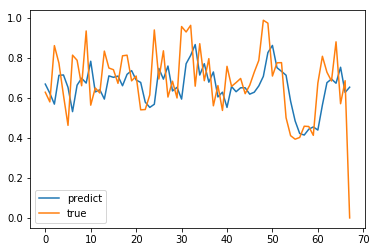

In [27]:
yhat = model.predict(testX)
plt.plot(yhat, label='predict')
plt.plot(testY, label='true')
plt.legend()

In [28]:
from math import sqrt
from sklearn.metrics import mean_squared_error
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.693


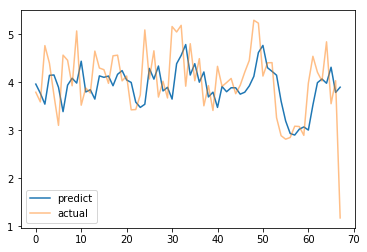

In [29]:
plt.plot(yhat_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)
plt.legend()